In [59]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date,timedelta
import time
import os
from IPython.display import clear_output
from plotly.subplots import make_subplots
from ta.volume import VolumeWeightedAveragePrice
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import mplfinance as mpf
import matplotlib.pyplot as plt
import datetime as dt

In [64]:
# Functions used in the code

def vwap(dataframe, label='vwap', window=10, fillna=True):
        dataframe[label] = VolumeWeightedAveragePrice(high=dataframe['High'], low=dataframe['Low'], close=dataframe["Adj Close"], volume=dataframe['Volume'], window=window, fillna=fillna).volume_weighted_average_price()
        return dataframe
def na_rows(df):
  '''
  This functions returns rows 
  where NaN values are present
  '''
  return df[df.isna().any(axis=1)]
def check_adfuller(df):
    # Dickey-Fuller test
    print("NULL HYPOTHESIS: time series is NOT stationary")
    print("ALTERNATE HYPOTHESIS: time series is stationary")
    result = adfuller(df, autolag = 'AIC')
    print('Test statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:' ,result[4])
    if (result[0] > result[4]["5%"]):
        print("Test statistic is greater than 5% critical value, ACCEPT NULL HYPOTHESIS")
    else:
        print("Test statistic is less than 5% critical value, REJECT NULL HYPOTHESIS")

    if result[1] < 0.05:
        print("p-value is less than 0.05, REJECT NULL HYPOTHESIS")
    else:
        print("p-value is greater than 0.05, ACCEPT NULL HYPOTHESIS")
        
def fn_keltner_channels(df,kc_lookback_period=7,KC_mult_high= 1): 
        
        df["KC_basis"]        = ta.SMA(df.Close, kc_lookback_period)
        df["devKC"]           = ta.SMA(ta.TRANGE(df.High,df.Low,df.Close),kc_lookback_period)
        df["KC_upper_high"]   = df.KC_basis + df.devKC * KC_mult_high
        df["KC_lower_high"]   = df.KC_basis - df.devKC * KC_mult_high

        return df
def fn_relative_strength(prices, n=14):

        deltas = np.diff(prices)
        seed = deltas[:n + 1]
        up = seed[seed >= 0].sum() / n
        down = -seed[seed < 0].sum() / n
        rs = up / down
        rsi = np.zeros_like(prices)
        rsi[:n] = 100. - 100. / (1. + rs)

        for i in range(n, len(prices)):
            delta = deltas[i - 1]  # cause the diff is 1 shorter

            if delta > 0:
                upval = delta
                downval = 0.
            else:
                upval = 0.
                downval = -delta

            up = (up * (n - 1) + upval) / n
            down = (down * (n - 1) + downval) / n

            rs = up / down
            rsi[i] = 100. - 100. / (1. + rs)

        return rsi

### FII DII Data

In [65]:
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding in encodings_to_try:
    try:
        FII_DII_Data = pd.read_csv('Fii_Dii.csv', encoding=encoding)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        pass
FII_DII_Data = pd.read_csv('Fii_Dii.csv', encoding=encoding)
FII_DII_Data['Date'] = pd.to_datetime(FII_DII_Data['Date'])

FII_DII_Data.set_index('Date', inplace=True)
FII_DII_Data

,FII_Gross_Purchase,FII_Gross_Sales,FII_Net,DII_Gross_Purchase,DII_Gross_Sales,DII_Net,Net_ FII_DII
Date,,,,,,,
2013-01-02,2341.67,1234.01,1107.66,1271.09,1688.50,-417.41,690.25
2013-01-03,3089.48,1692.11,1397.37,996.46,1902.42,-905.96,491.41
2013-01-04,3187.89,2023.48,1164.41,1148.55,1973.95,-825.40,339.01
2013-01-07,0.00,0.00,887.38,0.00,0.00,-1028.12,-140.74
2013-01-08,3177.07,2289.69,887.38,735.40,1763.52,-1028.12,-140.74
...,...,...,...,...,...,...,...
2023-08-07,11709.39,13602.16,-1892.77,7491.40,6410.60,1080.80,-811.97
2023-08-08,10721.75,11433.09,-711.34,8809.11,8271.80,537.31,-174.03
2023-08-09,9342.47,8698.36,644.11,8041.44,8639.32,-597.88,46.23


### OHLC Data with technical indicators

In [66]:
end_date = dt.datetime.now()
start_date = '2013-01-01'
df1=yf.download('^NSEI',start_date,end_date)
Nifty_OHLC=fn_keltner_channels(df1,kc_lookback_period=20,KC_mult_high= 1)
Nifty_OHLC['rsi'] =fn_relative_strength(Nifty_OHLC['Adj Close'], n=14)
vwap(Nifty_OHLC, label='vwap', window=3, fillna=True)
Nifty_OHLC

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,KC_basis,devKC,KC_upper_high,KC_lower_high,rsi,vwap
Date,,,,,,,,,,,,
2013-01-02,5982.600098,6006.049805,5982.000000,5993.250000,5993.250000,0,NaN,NaN,NaN,NaN,57.738595,0.000000
2013-01-03,6015.799805,6017.000000,5986.549805,6009.500000,6009.500000,0,NaN,NaN,NaN,NaN,57.738595,0.000000
2013-01-04,6011.950195,6020.750000,5981.549805,6016.149902,6016.149902,0,NaN,NaN,NaN,NaN,57.738595,0.000000
2013-01-07,6042.149902,6042.149902,5977.149902,5988.399902,5988.399902,0,NaN,NaN,NaN,NaN,57.738595,0.000000
2013-01-08,5983.450195,6007.049805,5964.399902,6001.700195,6001.700195,0,NaN,NaN,NaN,NaN,57.738595,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-08,19627.199219,19634.400391,19533.099609,19570.849609,19570.849609,260300,19644.922754,170.209961,19815.132715,19474.712793,53.790980,19549.455111
2023-08-09,19578.800781,19645.500000,19467.500000,19632.550781,19632.550781,266500,19657.335254,171.812500,19829.147754,19485.522754,56.016097,19580.718405
2023-08-10,19605.550781,19623.599609,19495.400391,19543.099609,19543.099609,312200,19663.802734,169.535059,19833.337793,19494.267676,52.099265,19570.754543


In [29]:
check_adfuller(Nifty_OHLC['Adj Close'])

NULL HYPOTHESIS: time series is NOT stationary
ALTERNATE HYPOTHESIS: time series is stationary
Test statistic: 0.08325783824418709
p-value: 0.9648992638088868
Critical Values: {'1%': -3.4328676030401115, '5%': -2.8626522824556213, '10%': -2.567362107840237}
Test statistic is greater than 5% critical value, ACCEPT NULL HYPOTHESIS
p-value is greater than 0.05, ACCEPT NULL HYPOTHESIS


#### PE,PB,DIV ratio data

In [67]:
from nsepython import *
import pandas as pd
symbol = "NIFTY 50"
start_date = "01-Jan-2013"
end_date = "11-Aug-2023"
pe_pb_data=pd.DataFrame(index_pe_pb_div(symbol,start_date,end_date))
pe_pb_data['Date'] = pd.to_datetime(pe_pb_data['DATE'])
pe_pb_data.set_index('Date', inplace=True)
#pe_pb_data.to_csv('pb_pe.csv')
pe_pb_data

,Index Name,pe,pb,divYield,DATE
Date,,,,,
2023-08-11,NIFTY 50,22.63,4.70,1.38,11 Aug 2023
2023-08-10,NIFTY 50,22.77,4.73,1.36,10 Aug 2023
2023-08-09,NIFTY 50,22.81,4.75,1.37,09 Aug 2023
2023-08-08,NIFTY 50,22.73,4.73,1.31,08 Aug 2023
2023-08-07,NIFTY 50,22.83,4.74,1.34,07 Aug 2023
...,...,...,...,...,...
2013-01-07,Nifty 50,18.94,3.18,1.38,07 Jan 2013
2013-01-04,Nifty 50,19.03,3.19,1.37,04 Jan 2013
2013-01-03,Nifty 50,19.01,3.19,1.37,03 Jan 2013


### Crude oil prices

In [68]:
end_date = dt.datetime.now()
start_date = '2013-01-01'
crude_prices=yf.download('CL=F',start_date,end_date)
vwap(crude_prices, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'crude_Open', 'High': 'crude_High','Low': 'crude_Low', 'Close': 'crude_Close','Adj Close': 'crude_Adj Close','Volume': 'crude_Volume','vwap':'crude_VWAP'}
crude_prices.rename(columns=new_column_names, inplace=True)
crude_prices

[*********************100%***********************]  1 of 1 completed


,crude_Open,crude_High,crude_Low,crude_Close,crude_Adj Close,crude_Volume,crude_VWAP
Date,,,,,,,
2013-01-02,91.779999,93.870003,91.559998,93.120003,93.120003,203865,92.850001
2013-01-03,92.910004,93.300003,92.489998,92.919998,92.919998,189812,92.875715
2013-01-04,92.860001,93.209999,91.519997,93.089996,93.089996,210747,92.781904
2013-01-07,93.209999,93.349998,92.419998,93.190002,93.190002,166292,92.817483
2013-01-08,93.320000,93.800003,92.669998,93.150002,93.150002,195867,92.922095
...,...,...,...,...,...,...,...
2023-08-08,82.529999,83.080002,79.900002,82.919998,82.919998,424545,82.219565
2023-08-09,82.879997,84.650002,82.669998,84.400002,84.400002,478140,82.812680
2023-08-10,84.250000,84.889999,82.580002,82.820000,82.820000,362188,83.119030


### USD-INR Prices

In [69]:
end_date = dt.datetime.now()
start_date = '2013-01-01'
USD_INR=yf.download('USDINR=X',start_date,end_date)
new_column_names = {'Open': 'USD_INR_Open', 'High': 'USD_INR_High','Low': 'USD_INR_Low', 'Close': 'USD_INR_Close','Adj Close': 'USD_INR_Adj Close','Volume': 'USD_INR_Volume'}
USD_INR.rename(columns=new_column_names, inplace=True)
USD_INR

[*********************100%***********************]  1 of 1 completed


,USD_INR_Open,USD_INR_High,USD_INR_Low,USD_INR_Close,USD_INR_Adj Close,USD_INR_Volume
Date,,,,,,
2013-01-01,54.993000,54.993000,54.667999,54.993000,54.993000,0
2013-01-02,54.681000,54.681000,54.099998,54.678001,54.678001,0
2013-01-03,54.348000,54.590000,54.150002,54.348000,54.348000,0
2013-01-04,54.452999,55.178001,54.353001,54.498001,54.498001,0
2013-01-07,55.064999,55.333000,54.880001,54.880001,54.880001,0
...,...,...,...,...,...,...
2023-08-08,82.748299,82.984299,82.718300,82.748299,82.748299,0
2023-08-09,82.845001,83.106300,82.786102,82.845001,82.845001,0
2023-08-10,82.866302,82.867302,82.584099,82.866302,82.866302,0


### Gold prices

In [70]:
end_date = dt.datetime.now()
start_date = '2013-01-01'
Gold_price=yf.download('GC=F',start_date,end_date)
vwap(Gold_price, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'Gold_price_Open', 'High': 'Gold_price_High','Low': 'Gold_price_Low', 'Close': 'Gold_price_Close','Adj Close': 'Gold_price_Adj Close','Volume': 'Gold_price_Volume','vwap':'Gold_price_VWAP'}
Gold_price.rename(columns=new_column_names, inplace=True)
Gold_price

[*********************100%***********************]  1 of 1 completed


,Gold_price_Open,Gold_price_High,Gold_price_Low,Gold_price_Close,Gold_price_Adj Close,Gold_price_Volume,Gold_price_VWAP
Date,,,,,,,
2013-01-02,1672.800049,1693.800049,1670.000000,1687.900024,1687.900024,35,1683.900024
2013-01-03,1686.099976,1686.800049,1662.000000,1673.699951,1673.699951,140,1676.113338
2013-01-04,1647.000000,1658.300049,1625.699951,1648.099976,1648.099976,199,1659.044026
2013-01-07,1656.500000,1659.900024,1643.800049,1645.500000,1645.500000,49,1655.626030
2013-01-08,1647.699951,1661.500000,1647.699951,1661.500000,1661.500000,17,1645.912702
...,...,...,...,...,...,...,...
2023-08-08,1931.699951,1933.199951,1923.000000,1924.099976,1924.099976,555,1931.154046
2023-08-09,1925.400024,1928.800049,1913.699951,1915.400024,1915.400024,451,1926.506558
2023-08-10,1921.099976,1927.800049,1911.400024,1914.400024,1914.400024,178,1922.584512


### S&P 500

In [71]:
end_date = dt.datetime.now()
start_date = '2013-01-01'
SP500=yf.download('^GSPC',start_date,end_date)
vwap(SP500, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'SP500_Open', 'High': 'SP500_High','Low': 'SP500_Low', 'Close': 'SP500_Close','Adj Close': 'SP500_Adj Close','Volume': 'SP500_Volume','vwap':'SP500_VWAP'}
SP500.rename(columns=new_column_names, inplace=True)
SP500

[*********************100%***********************]  1 of 1 completed


,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SP500_VWAP
Date,,,,,,,
2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,1462.420044,4202600000,1450.346680
2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,1459.369995,3829730000,1455.008084
2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,1466.469971,3424290000,1457.835167
2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,1461.890015,3304970000,1462.012845
2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,1457.150024,3601600000,1460.928516
...,...,...,...,...,...,...,...
2023-08-07,4491.580078,4519.839844,4491.149902,4518.439941,4518.439941,3493920000,4502.890395
2023-08-08,4498.029785,4503.310059,4464.390137,4499.379883,4499.379883,3884910000,4498.426133
2023-08-09,4501.569824,4502.439941,4461.330078,4467.709961,4467.709961,3803100000,4491.484641


In [10]:
end_date = dt.datetime.now()
start_date = '2013-01-01'
SGXNIFTY=yf.download('^SGXNIFTY',start_date,end_date)
vwap(SGXNIFTY, label='vwap', window=3, fillna=True)
#new_column_names = {'Open': 'SP500_Open', 'High': 'SP500_High','Low': 'SP500_Low', 'Close': 'SP500_Close','Adj Close': 'SP500_Adj Close','Volume': 'SP500_Volume','vwap':'SP500_VWAP'}
#SP500.rename(columns=new_column_names, inplace=True)
SGXNIFTY

[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['^SGXNIFTY']: Exception('^SGXNIFTY: No timezone found, symbol may be delisted')


,Open,High,Low,Close,Adj Close,Volume,vwap
Date,,,,,,,


### Top 10 stocks

In [72]:
ticker_list=['HDFCBANK.NS','RELIANCE.NS','ICICIBANK.NS','INFY.NS','ITC.NS','TCS.NS','LT.NS','KOTAKBANK.NS','AXISBANK.NS','SBIN.NS']
df_Top_stocks=pd.DataFrame()
for ticker in ticker_list:
    end_date = dt.datetime.now()
    start_date = '2013-01-01'
    df=yf.download(ticker,start_date,end_date)
    vwap(df, label='vwap', window=3, fillna=True)
    df_Top_stocks[f'{ticker}_VWAP']=df['vwap']
    clear_output(wait=False)
df_Top_stocks

,HDFCBANK.NS_VWAP,RELIANCE.NS_VWAP,ICICIBANK.NS_VWAP,INFY.NS_VWAP,ITC.NS_VWAP,TCS.NS_VWAP,LT.NS_VWAP,KOTAKBANK.NS_VWAP,AXISBANK.NS_VWAP,SBIN.NS_VWAP
Date,,,,,,,,,,
2013-01-01,332.655436,407.606934,200.778946,266.769465,176.210648,590.005483,683.433858,325.195221,267.980743,233.324142
2013-01-02,333.942628,409.752905,202.579777,266.678165,175.705351,589.922767,688.704489,327.129617,270.338868,234.736426
2013-01-03,333.733950,411.771292,202.998889,267.882162,175.200259,592.520081,689.719809,327.272140,271.130016,235.832185
2013-01-04,332.771634,413.761684,204.198658,268.864926,174.243872,598.641455,689.692816,327.400155,271.549958,237.576252
2013-01-07,330.419048,415.422649,204.767162,270.269007,172.854880,601.564116,682.105889,325.488901,271.079451,238.267391
...,...,...,...,...,...,...,...,...,...,...
2023-08-08,1649.327039,2506.002768,970.620729,1383.230573,454.777384,3458.727073,2631.044529,1831.822614,949.458474,575.903448
2023-08-09,1649.259633,2514.252340,972.879350,1389.597130,454.356913,3464.844369,2638.339127,1831.238588,950.299345,571.395658
2023-08-10,1644.687820,2520.773603,971.017466,1390.167705,453.973980,3457.638298,2640.125876,1820.984413,947.713484,572.775584


In [112]:
# all data combined in one dataframe
concatenated_df = pd.concat([Nifty_OHLC, FII_DII_Data,pe_pb_data,crude_prices,USD_INR,Gold_price,SP500,df_Top_stocks], axis=1)
concatenated_df.dropna(inplace=True,axis=0)

# Previous day values used to predict current day price

#columns_to_shift = ['Adj Close','Volume','vwap','KC_basis','devKC','rsi','FII_Net','DII_Net','pe','pb','crude_Adj Close','USD_INR_Adj Close','Gold_price_Adj Close','SP500_Adj Close','HDFCBANK.NS', 'RELIANCE.NS','ICICIBANK.NS','INFY.NS','ITC.NS','TCS.NS','LT.NS','KOTAKBANK.NS','AXISBANK.NS','SBIN.NS']
columns_to_shift = ['Adj Close','Volume','vwap','KC_basis','devKC','rsi','FII_Net','DII_Net','pe','pb','crude_VWAP','USD_INR_Adj Close','Gold_price_VWAP','SP500_VWAP','HDFCBANK.NS_VWAP', 'RELIANCE.NS_VWAP','ICICIBANK.NS_VWAP','INFY.NS_VWAP','ITC.NS_VWAP','TCS.NS_VWAP','LT.NS_VWAP','KOTAKBANK.NS_VWAP','AXISBANK.NS_VWAP','SBIN.NS_VWAP']

# Number of previous days to shift
num_days = 1
new_columns_list=[]
# Create previous day columns using a loop
for column in columns_to_shift:
    for i in range(1, num_days + 1):
        concatenated_df[f'{column}_prev_{i}'] = concatenated_df[column].shift(i)
        new_columns_list.append(f'{column}_prev_{i}')

concatenated_df.to_csv('x.csv')


 Coefficient for Adj Close_prev_1: 1.0018056274024372

 Coefficient for KC_basis_prev_1: -0.003076828738143833

 Coefficient for devKC_prev_1: 0.0017280338277229537

 Coefficient for rsi_prev_1: -0.08982254699586616

 Coefficient for FII_Net_prev_1: 0.006086467927111458

 Coefficient for DII_Net_prev_1: 0.0059665376907486415

 Coefficient for pe_prev_1: 0.34967585266542534

 Coefficient for USD_INR_Adj Close_prev_1: 0.9888869240868229

 R-squared: 0.9990785276765516

 Mean Squared Error: 14299.848089258076

 Root Mean Squared Error: 119.58197225860626


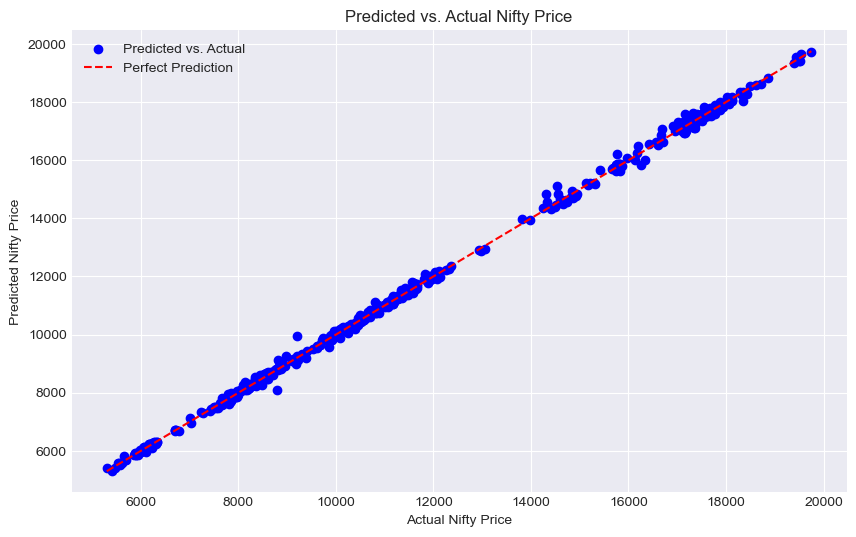

In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data =concatenated_df
data.dropna(inplace=True,axis=0)
# Splitting the data into features (input factors) and target variable
X = data[['Adj Close_prev_1','KC_basis_prev_1','devKC_prev_1','rsi_prev_1','FII_Net_prev_1','DII_Net_prev_1','pe_prev_1','USD_INR_Adj Close_prev_1']]

y = data['Adj Close'] 


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions
predictions = model.predict(X_test)

coefficients = model.coef_

# Printing the coefficients
for i, coef in enumerate(coefficients):
    print(f'\n Coefficient for {X.columns[i]}:', coef)

r_squared = model.score(X, y)

print("\n R-squared:", r_squared)    
    
# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("\n Mean Squared Error:", mse)
print("\n Root Mean Squared Error:", rmse)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.xlabel('Actual Nifty Price')
plt.ylabel('Predicted Nifty Price')
plt.title('Predicted vs. Actual Nifty Price')
plt.legend()
plt.show()

In [104]:
# prediction for tomorrow's Nifty price
example_factors = np.array([[19428.30078,19656.9927734375, 167.705078125,47.5080721330983,-3073.28,500.35,22.63,82.79989624]])
predicted_nifty_price = model.predict(example_factors)

print("Predicted Nifty Price for Tomorrow:", predicted_nifty_price)

Predicted Nifty Price for Tomorrow: [19420.24470378]
